### BG Model

In [ ]:
import gym
from gym import wrappers
from agent import Agent
import numpy as np
import time
import matplotlib.pyplot as plt
from statistics import mean
from tqdm import tqdm

def bins(clip_min, clip_max, num):
    """Convert observed state to discrete digital values"""
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]


def digitize_state(observation, num_dizitized):
    """Convert each value to discrete values"""
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, num_dizitized)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, num_dizitized)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, num_dizitized)),
        np.digitize(pole_v, bins=bins(-2.0, 2.0, num_dizitized))
    ]
    return sum([x * (num_dizitized**i) for i, x in enumerate(digitized)]), digitized


def train():
    global cart_bg, bg_total, ave_step
    n = 200
    bg_total = []
    ave_step = []
    for x in tqdm(range(1, n+1)):
        num_dizitized = 6 # Number of bins
        max_number_of_steps = 200 # Number of steps per trial
        num_episodes = 800 # Total number of trials
        final_x = np.zeros((num_episodes, 1)) # Store the x position at t=200 after learning
        islearned = 0 # Flag indicating whether learning is complete
        _log_step = [] # Memory for action count
        log_step = [] # Memory for action count
        env = gym.make('CartPole-v1')
        agent = Agent(num_dizitized**4)

        for episode in range(1, num_episodes + 1): # Repeat for the number of trials
            observation, info = env.reset()
            state, state_dim = digitize_state(observation, num_dizitized) # state_dim: List of bins [c_pos, c_v, p_pos, p_v]
            pre_state = state
            action = agent.get_action(episode, state)
            episode_reward = 0
            a_cnt = 0

            for t in range(1, max_number_of_steps+1): # Loop for one trial
                cart_pos, cart_v, pole_angle, pole_v = observation
                agent.learn_fh(state, pre_state, action, a_cnt) # bg_loop first half
                action = agent.get_action(episode, state) # Decide action using policy
                a_cnt += 1 # Count actions
                observation, reward, done, truncated, info = env.step(action)

                if done:
                    if t < 195:
                        reward = -1 # Penalty for falling -200
                    else:
                        reward = 1 # No penalty for standing at the end 1
                else:
                    reward = 0 # Add reward for standing at each step 0

                episode_reward += reward # Add reward
                next_state, state_dim = digitize_state(observation, num_dizitized) # Convert observed state at t+1 to discrete values
                pre_state = state
                state = next_state
                agent.learn_sh(pre_state, state, a_cnt, action, reward, episode, cart_pos, cart_v, pole_angle, pole_v, state_dim) # bg_loop second half

                if done or t == max_number_of_steps:
                    _log_step.append(a_cnt)
                    log_step.append(_log_step)
                    _log_step = []
                    
                    if islearned == 1: # If learning is complete, store the final x coordinate
                        final_x[episode, 0] = observation[0]
                    break
#         agent.writer(x)
        
#         cart_bg = log_step
#         # Display learning curve
#         x = np.arange(1, num_episodes+ 1)
#         y = np.squeeze(log_step)
#         ave_step.append(y)
        
#         # smoothing
#         window = np.ones(20)/20
#         y = np.convolve(y,window, mode="same")
        
#         plt.figure(figsize=(16, 8))
#         plt.plot(x, y, label='Label')
#         plt.legend()
#         plt.title('Change the number of steps')
#         plt.xlabel('Episode')
#         plt.ylabel('Steps')
#         plt.grid(True)
#         plt.show()

        
        bg_total.append(log_step)
#     print(bg_total)
    
if __name__ == "__main__":
    train()

In [ ]:
import pandas as pd

# Given data
data = bg_total

# Create a list to save the data
flattened_data = []

# Expand the data for each epoch and episode
for epoch_idx, epoch in enumerate(data, start=1):  # Start from the first epoch
    for episode_idx, steps in enumerate(epoch, start=1):  # Start from the first episode
        flattened_data.append([epoch_idx, episode_idx, steps[0]])  # Retrieve steps[0]

# Create a pandas DataFrame
df = pd.DataFrame(flattened_data, columns=["Epoch", "Episode", "Steps"])

# Save to a CSV file (saved in UTF-8)
df.to_csv("cartpole_epochs.csv", index=False, encoding="utf-8")


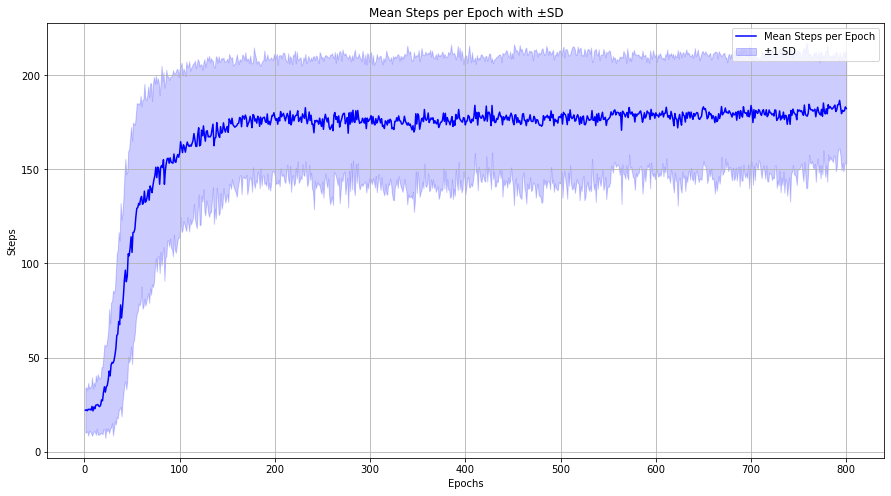

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("cartpole_epochs.csv")  # File name can be changed as needed

# Get the maximum values of the `Epoch` and `Episode` columns (to determine matrix size)
num_epochs = df["Epoch"].max()
num_episodes = df["Episode"].max()

# Convert to a (200, 800) `numpy` array
data = np.zeros((num_epochs, num_episodes))  # Initialize with zeros

# Store the data in the `numpy` array
for _, row in df.iterrows():
    epoch_idx = row["Epoch"] - 1   # Convert to 0-based index
    episode_idx = row["Episode"] - 1  # Convert to 0-based index
    data[epoch_idx, episode_idx] = row["Steps"]

# print(data)
# Calculate the mean and standard deviation for each epoch
epoch_mean = np.mean(data, axis=0)  # Mean for each epoch (vertical axis)
epoch_std = np.std(data, axis=0)    # Standard deviation for each epoch (vertical axis)
# print(epoch_mean)

# Plot the graph
plt.figure(figsize=(15,8))
plt.plot(range(1, 801), epoch_mean, label="Mean Steps per Epoch", color='b')
plt.fill_between(range(1, 801), epoch_mean - epoch_std, epoch_mean + epoch_std, color='b', alpha=0.2, label="±1 SD")

plt.xlabel("Epochs")
plt.ylabel("Steps")
plt.title("Mean Steps per Epoch with ±SD")
plt.legend()
plt.grid()
plt.savefig('Learning_results.svg')
plt.show()


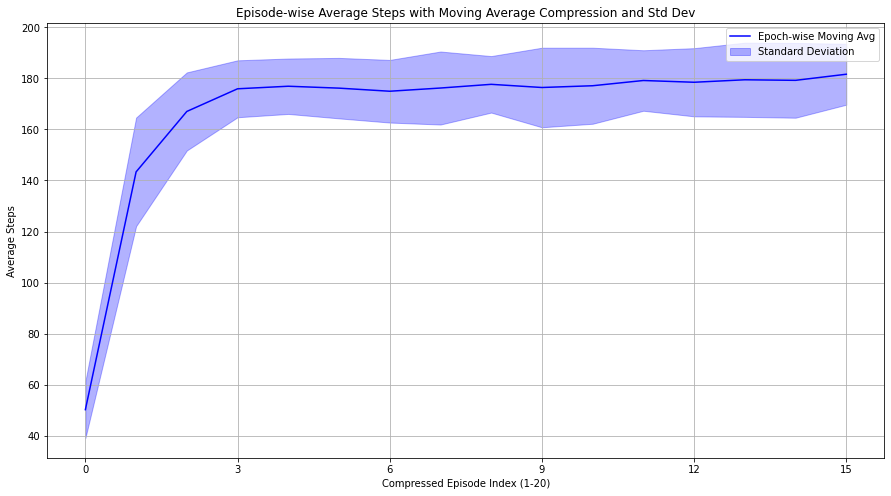

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("cartpole_epochs.csv")  # For comma-separated values

# **1. Calculate the epoch mean for each episode**
episode_mean = df.groupby(["Epoch", "Episode"])["Steps"].mean().unstack(level=0)  # Episode mean for each epoch

# **2. Apply moving average and compress into 20 episodes**
num_episodes = len(episode_mean)
window_size = num_episodes // 16  # Example: If there are 800 episodes, compress into groups of 40
compressed_episodes = episode_mean.rolling(window=window_size).mean()[window_size-1::window_size]

# **3. Calculate the compressed mean and standard deviation for each epoch**
epoch_mean = compressed_episodes.mean(axis=1)  # Mean for each epoch
epoch_std = compressed_episodes.std(axis=1)  # Standard deviation for each epoch

# **4. Change the X-axis to compressed episode indices (1-20)**
compressed_x = np.arange(0, len(epoch_mean)).astype(int)  # Convert X-axis to integers

# **5. Plot the results (with error shade)**
plt.figure(figsize=(15,8))
plt.plot(compressed_x, epoch_mean, linestyle="-", label="Epoch-wise Moving Avg", color='b')
plt.fill_between(compressed_x, epoch_mean - epoch_std, epoch_mean + epoch_std, alpha=0.3, label="Standard Deviation", color='b')
plt.xlabel("Compressed Episode Index (1-20)")
plt.ylabel("Average Steps")
plt.title("Episode-wise Average Steps with Moving Average Compression and Std Dev")
plt.xticks(compressed_x[::3])  # Display X-axis ticks every 5 steps
plt.legend()
plt.grid()
plt.savefig('Moving_average.svg')
plt.show()

### Moving average（pandas.rolling()）

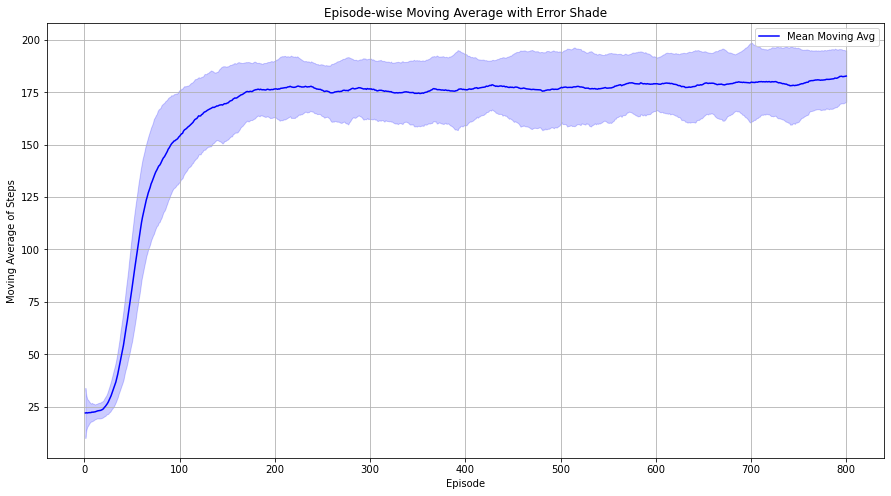

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("cartpole_epochs.csv")

# Window size for moving average (e.g., set to 20)
window_size = 20

# Calculate moving average for each epoch
df["Moving_Avg"] = df.groupby("Epoch")["Steps"].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

# Calculate the mean and standard deviation of the moving average for each episode
episode_mean = df.groupby("Episode")["Moving_Avg"].mean()
episode_std = df.groupby("Episode")["Moving_Avg"].std()

# X-axis (Episode) and Y-axis (Mean of moving average)
episodes = episode_mean.index
steps_mean = episode_mean.values
steps_std = episode_std.values

# Replace NaN with 0 (considering the possibility of std being NaN)
steps_std = np.nan_to_num(steps_std)

# Plot with error shade
plt.figure(figsize=(15,8))
plt.plot(episodes, steps_mean, label="Mean Moving Avg", color="b")
plt.fill_between(episodes, steps_mean - steps_std, steps_mean + steps_std, color="b", alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Moving Average of Steps")
plt.title("Episode-wise Moving Average with Error Shade")
plt.legend()
plt.grid()
plt.savefig('Moving_average_rolling.svg')
plt.show()

### Moving average（numpy.convolve()）

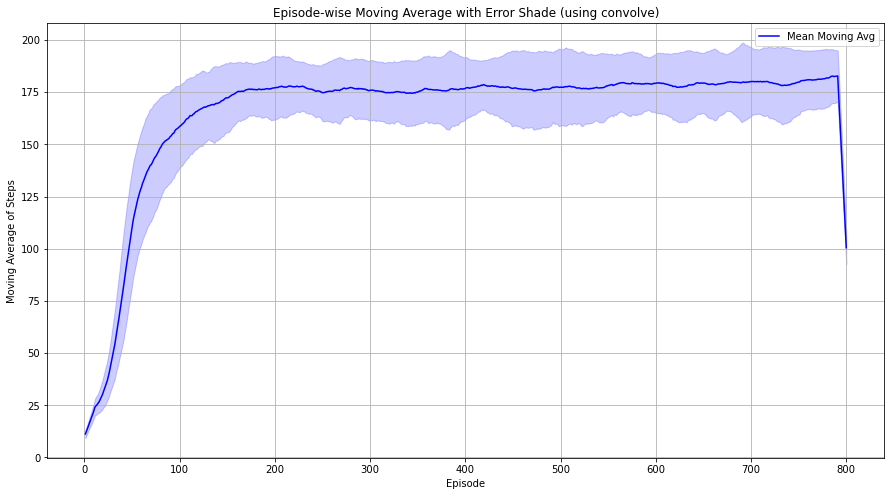

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("cartpole_epochs.csv")

# Window size for moving average (e.g., set to 20)
window_size = 20

# Create a kernel (for moving average)
kernel = np.ones(window_size) / window_size

# Calculate moving average for each epoch
# Use convolve to calculate the moving average
df["Moving_Avg"] = df.groupby("Epoch")["Steps"].transform(
    lambda x: np.convolve(x, kernel, mode="same")  # 'same' mode to keep the same length as the original data
)

# Calculate the mean and standard deviation of the moving average for each episode
episode_mean = df.groupby("Episode")["Moving_Avg"].mean()
episode_std = df.groupby("Episode")["Moving_Avg"].std()

# X-axis (Episode) and Y-axis (Mean of moving average)
episodes = episode_mean.index
steps_mean = episode_mean.values
steps_std = episode_std.values

# Replace NaN with 0 (considering the possibility of std being NaN)
steps_std = np.nan_to_num(steps_std)

# Plot with error shade
plt.figure(figsize=(15,8))
plt.plot(episodes, steps_mean, label="Mean Moving Avg", color="b")
plt.fill_between(episodes, steps_mean - steps_std, steps_mean + steps_std, color="b", alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Moving Average of Steps")
plt.title("Episode-wise Moving Average with Error Shade (using convolve)")
plt.legend()
plt.grid()
plt.savefig('Moving_average_convolve.svg')
plt.show()


200step達成割合 : 39.5%


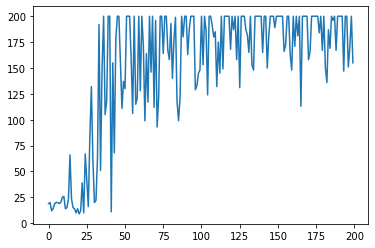

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file as a DataFrame
df = pd.read_csv(f'sampleBG-1.csv')
df = df.groupby('episode')['a_cnt'].max().reset_index()
df = df['a_cnt']

x = np.arange(200)
y = df
plt.plot(x, y)

"""Percentage of episodes achieving 200 steps"""
count = 0
for element in df:
    if element == 200:
        count += 1

ave = count / (200) * 100
print(f'Percentage of episodes achieving 200 steps: {ave}%')

Text(0.5, 1.0, 'STN activity')

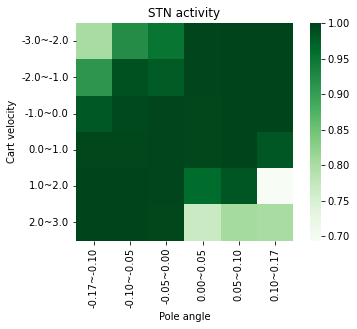

In [ ]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

i= 1
file_name = f"sampleBG-1.csv"
df = pd.read_csv(file_name)

# Divide 'pole_v' into bins and label them
a = pd.cut(df['pole_v'], [-2.0, -1.3, -0.7, 0, 0.7, 1.3, 2.0], labels=['-2.0~-1.3','-1.3~-0.7','-0.7~0.0','0.0~0.7', '0.7~1.3', '1.3~2.0'])
vertical = pd.DataFrame(a)

# Divide 'pole_angle' into bins and label them
b = pd.cut(df['pole_angle'], [-0.17, -0.10, -0.05, 0, 0.05, 0.10, 0.17], labels=['-0.5~-0.33','-0.33~-0.17','-0.17~0.0','0.0~0.17', '0.17~0.33', '0.33~0.5'])
horizontal = pd.DataFrame(b)

stn = df['STN']

# Concatenate data horizontally [element1, element2, STN in order]
data = pd.concat([vertical, horizontal], axis=1)
data = pd.concat([data, stn], axis=1)

# Group by 'pole_v' and 'pole_angle' and calculate the mean of the 'STN' element
edit_data = data.groupby(['pole_v','pole_angle'], as_index=False)['STN'].mean()
edit_data = pd.DataFrame(edit_data)

stn_value = edit_data.values.tolist()
map_size = np.zeros([6, 6])

# Populate the map_size array with STN values
count = 0
for i in range(6):
    for j in range(6):
        map_size[i][j] = stn_value[count][2]       
        count += 1

# Create a heatmap
sns.heatmap(map_size, annot=False, square=True, cmap='Greens', yticklabels=['-3.0~-2.0','-2.0~-1.0','-1.0~0.0','0.0~1.0', '1.0~2.0', '2.0~3.0'],xticklabels=['-0.17~-0.10','-0.10~-0.05','-0.05~0.00','0.00~0.05', '0.05~0.10', '0.10~0.17'])
plt.xlabel('Pole angle')
plt.ylabel('Cart velocity')
plt.title('STN activity')

#### Average learning rate

Text(0.5, 1.0, 'average learning rate')

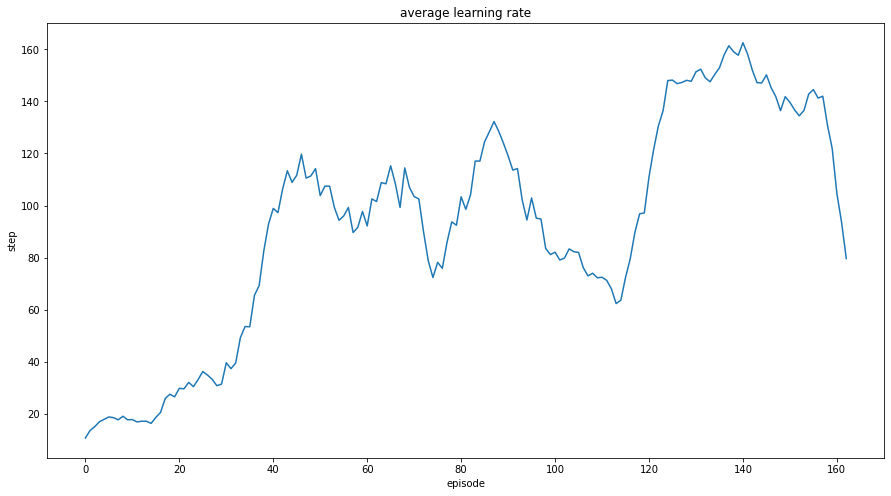

In [24]:
ave_step = np.mean(ave_step, axis=0)
x = np.arange(len(ave_step))

window = np.ones(11)/11
y = np.convolve(ave_step, window, mode="same")
plt.figure(figsize=(15,8))
plt.plot(x, y)
plt.xlabel("episode")
plt.ylabel("step")
plt.title("average learning rate")

### Percentage of episodes achieving 200 steps

1. stand, fall, success = 1, -200, 200 → 49.25%
2. stand, fall, success = 1, -200, 0 → 31.125%

In [ ]:

t = np.arange(16)
ave = np.mean(bg_total, axis=0)
sigma = np.std(bg_total, axis=0)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(t, ave, lw=5, label='bg_model_cartpole', color='blue')
ax.fill_between(t, ave+sigma, ave-sigma, facecolor='blue', alpha=0.5)
ax.set_title('bg_model_cartpole', fontsize=20)
# ax.legend(loc='upper right')
ax.tick_params(labelsize=20)
ax.set_xlabel('trial', fontsize=20)
ax.set_ylabel('total_action', fontsize=20)